In [22]:
import lb_scrapper as lbs
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import re
import numpy as np

# How to use the scrapper
## The scrapper object
The scrapper is a simple class with a few built-in methods. A lot of arguments are optionnal. For complete documentation see the code.

In [23]:
mscrapper = lbs.request_lb(request="", dataname="Lyon_rent")
mscrapper.check_nb_entries()

Currently, 2083 entries.


We can extend the scrapping by calling the `update_db` method.

In [3]:
mscrapper.update_db(nb_iter=20,step=1)

Committing 1 new lines
[==------------------------------------------------] 5.00%
Committing 1 new lines
[=====---------------------------------------------] 10.00%
Committing 1 new lines
[=======-------------------------------------------] 15.00%
Committing 1 new lines
[==========----------------------------------------] 20.00%
Committing 1 new lines
[============--------------------------------------] 25.00%
Committing 1 new lines
[===============-----------------------------------] 30.00%
Committing 1 new lines
[=================---------------------------------] 35.00%
Committing 1 new lines
[====================------------------------------] 40.00%
Committing 1 new lines
[======================----------------------------] 45.00%
Committing 1 new lines
[=========================-------------------------] 50.00%
Committing 1 new lines
[===========================-----------------------] 55.00%
Committing 1 new lines
[==============================--------------------] 60.00%
Commi

As the results are stored in a SQL database, we can convert it to a dataframe to explore it.

In [24]:
conn = sqlite3.connect('./datas/scrapped_lbc.db')
df = pd.read_sql_query("select * from Lyon_rent;", conn)
df.columns.tolist()

['link',
 'title',
 'price',
 'city',
 'nb_rooms',
 'surface',
 'charges',
 'furnished',
 'description',
 'update_date']

The columns are the following :
- link: link to the post
- title: title of the post
- price: rent in euro
- city: postcode, gives the area in Lyon
- nb_rooms: number of rooms (living room, bedrooms)
- surface: size in square meter
- charges: are the charges included or not in the price
- furnished: are the furniture included
- description: content of the post (in french)
- update_date: date of collect

## Working with datas

As the datas are raw, we need to clean them a bit and change some things.

### Quick work on the features

First, let's convert the city as an ordered factor, as it is easier to understand.

In [25]:
df.city=pd.Categorical(df.city, categories=sorted(df.city.unique().tolist()),ordered=True)

Now let us add two dummy factors, to check if there is a parking slot, or a balcony included.

In [26]:
df['TOP_parking']=df.description.str.contains(re.compile("parking|garage",re.IGNORECASE))

In [27]:
df['TOP_balcon']=df.description.str.contains(re.compile("terrasse|balcon",re.IGNORECASE))

The bascic stastistics for numerical variables are the following :

In [28]:
df.select_dtypes(include=[np.number,bool]).astype(float).describe()

,price,nb_rooms,surface,TOP_parking,TOP_balcon
count,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000
mean,850.614018,2.572732,54.466155,0.293327,0.265963
std,245.811946,0.697784,20.968440,0.455396,0.441950
min,500.000000,2.000000,1.000000,0.000000,0.000000
25%,663.000000,2.000000,40.000000,0.000000,0.000000
50%,800.000000,2.000000,53.000000,0.000000,0.000000
75%,965.500000,3.000000,68.000000,1.000000,1.000000
max,1700.000000,5.000000,160.000000,1.000000,1.000000


As expected, the price goes from 500 to 1500, with a mean of 950, which is slightly higher than the median. The Q1-Q3 interval is approx. 800 to 1000, which means that a lot of prices are in that range.

For our price range, the number of rooms evolve from 3 to 5, but actually most of the offers are for 3 rooms as we can see.

A lot of surfaces values are equal to 1, which is a mistake or a mislead, so we can delete it.

In [29]:
df.loc[df.surface == 1,"surface"] = None

In [30]:
df.select_dtypes(include=[np.number,bool]).astype(float).describe()

,price,nb_rooms,surface,TOP_parking,TOP_balcon
count,2083.000000,2083.000000,2026.000000,2083.000000,2083.000000
mean,850.614018,2.572732,55.970385,0.293327,0.265963
std,245.811946,0.697784,19.217767,0.455396,0.441950
min,500.000000,2.000000,12.000000,0.000000,0.000000
25%,663.000000,2.000000,41.000000,0.000000,0.000000
50%,800.000000,2.000000,54.000000,0.000000,0.000000
75%,965.500000,3.000000,68.000000,1.000000,1.000000
max,1700.000000,5.000000,160.000000,1.000000,1.000000


The surface goes from 24 to 115, with most of the offers between 60 and 78.

Finally, the parking and balcony are not as seldom as in paris, since a third of the sample seems to have one.

### What does it looks like ?

Let's explore a bit further the variable, to see what we have

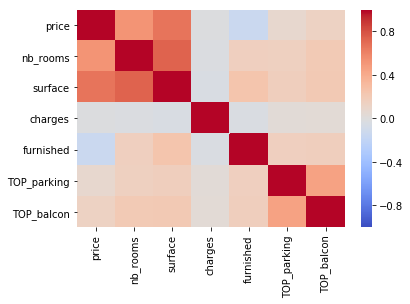

,price,nb_rooms,surface,charges,furnished,TOP_parking,TOP_balcon
price,1.000000,0.526267,0.667754,-0.012870,-0.138983,0.081107,0.139116
nb_rooms,0.526267,1.000000,0.734436,-0.016719,0.160314,0.154765,0.208522
surface,0.667754,0.734436,1.000000,-0.031326,0.244144,0.166709,0.215190
charges,-0.012870,-0.016719,-0.031326,1.000000,-0.026150,0.037693,0.046747
furnished,-0.138983,0.160314,0.244144,-0.026150,1.000000,0.161212,0.170892
TOP_parking,0.081107,0.154765,0.166709,0.037693,0.161212,1.000000,0.454868
TOP_balcon,0.139116,0.208522,0.215190,0.046747,0.170892,0.454868,1.000000


In [31]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df2=df.drop(["link","title","description","update_date"],axis=1).copy().dropna()
for x in df2.columns:
    if df2[x].dtypes=='object':
        df2[x]=le.fit_transform(df2[x])

corr = df2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="coolwarm",
           vmin = -1, vmax =1)
plt.show()
display(corr)
del df2

The correlation matrix is interesting. It shows us that the greatest positive correlation are Price/Surface and Parking/Balcony. The first one is not so surprising, but the value (approx. 1/2) shows that the link is not totally linear between the two variables.

For the second one, we can conclude that when you have a parking, you are likely to have a balcony. 

We also have a good correlation between surface and number of rooms, which is expected.

Finally the most surprising part is that furnished flats tends to be cheaper than other one. 

The different suburbs of Lyon might also impact the price and surface.

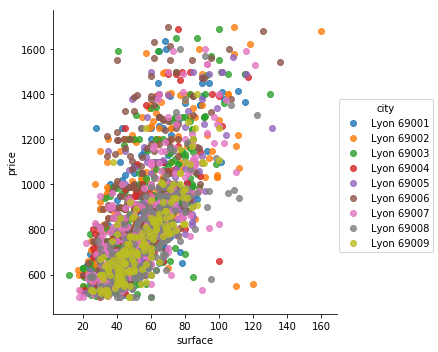

In [32]:
sns.lmplot(y="price",x='surface', hue="city",data=df,fit_reg=False)
plt.show()

We saw that the correlation is positive between price and surface. By coloring the point by area we see that some area tends to be more expensive than other, but without separating the graphs it is hard to see.

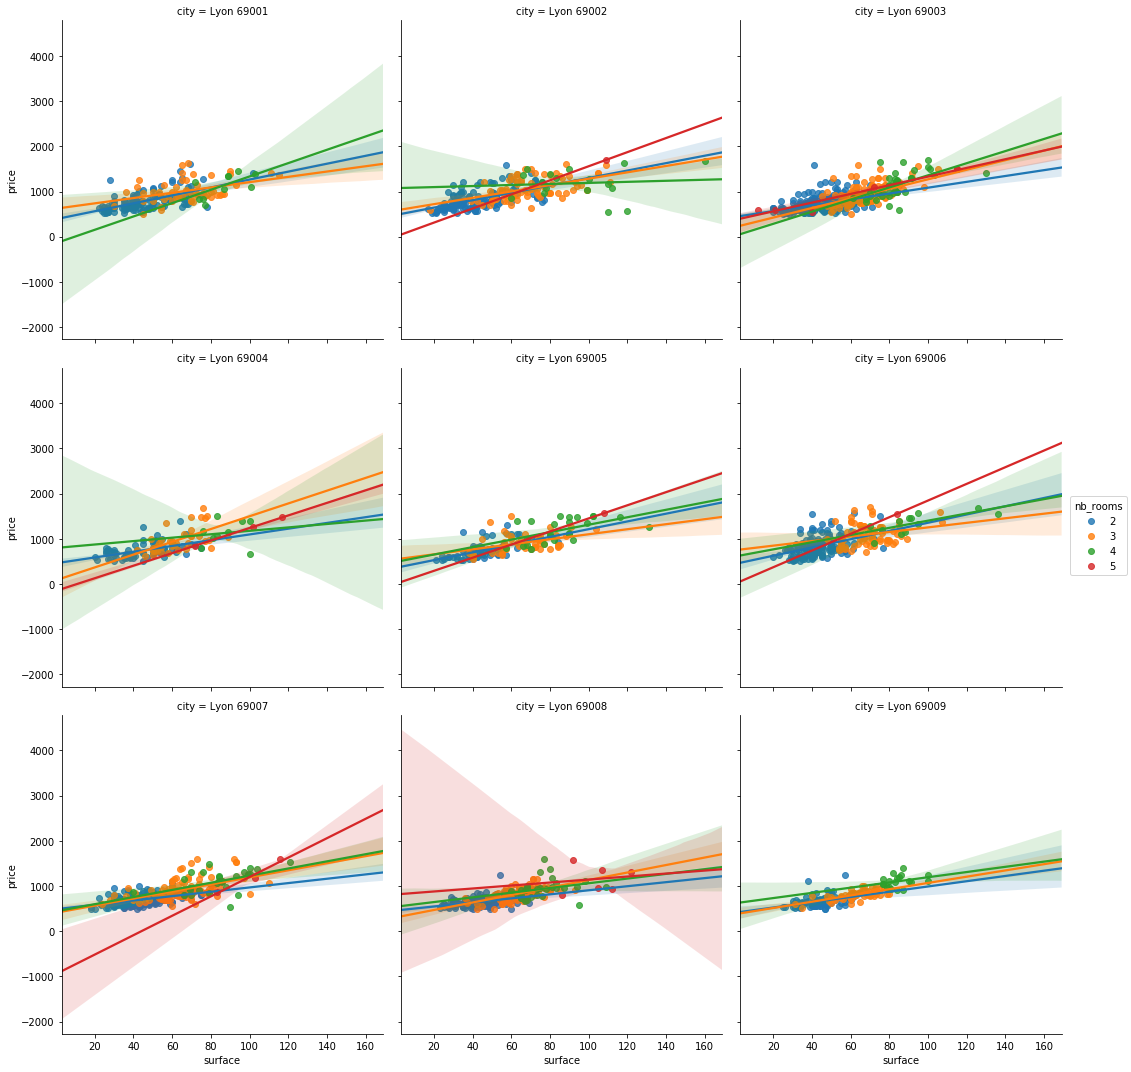

In [43]:
sns.lmplot(y="price",x='surface', hue="nb_rooms", col="city",data=df,col_wrap=3)
plt.show()

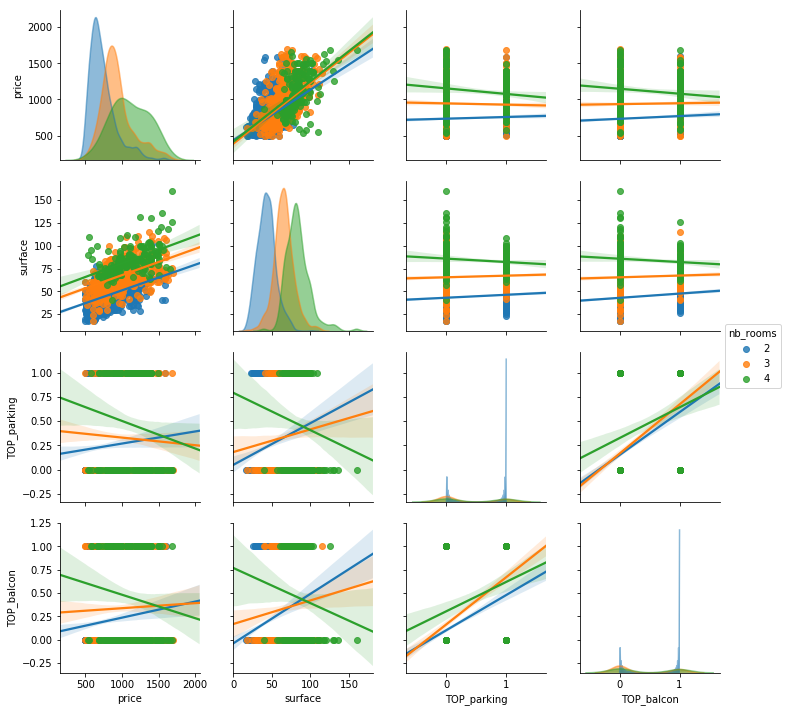

In [34]:
sns.pairplot(df[df.nb_rooms != 5].dropna(), kind="reg",hue="nb_rooms",diag_kind="kde",diag_kws=dict(shade=True, alpha = 0.5),
            vars=['price','surface','TOP_parking','TOP_balcon'])
plt.show()

Depending on the areas, the slopes are different. It is interesting to see that contrary to the complete scatterplot, here the relationship between price and surface seems to be clearer, with less volatility.

### Words analysis

We have all the descriptions available here, but it is hard to extract feature manually. We are going to use some of NLTK tools to ease the process.

In [35]:
from wordcloud import WordCloud

In [36]:
from nltk.corpus import stopwords
import nltk
import string

In [37]:
text_desc = ' '.join(df.description)
text_desc = [word for word in nltk.word_tokenize(text_desc) 
             if word.lower() not in stopwords.words('french') and word not in string.punctuation]

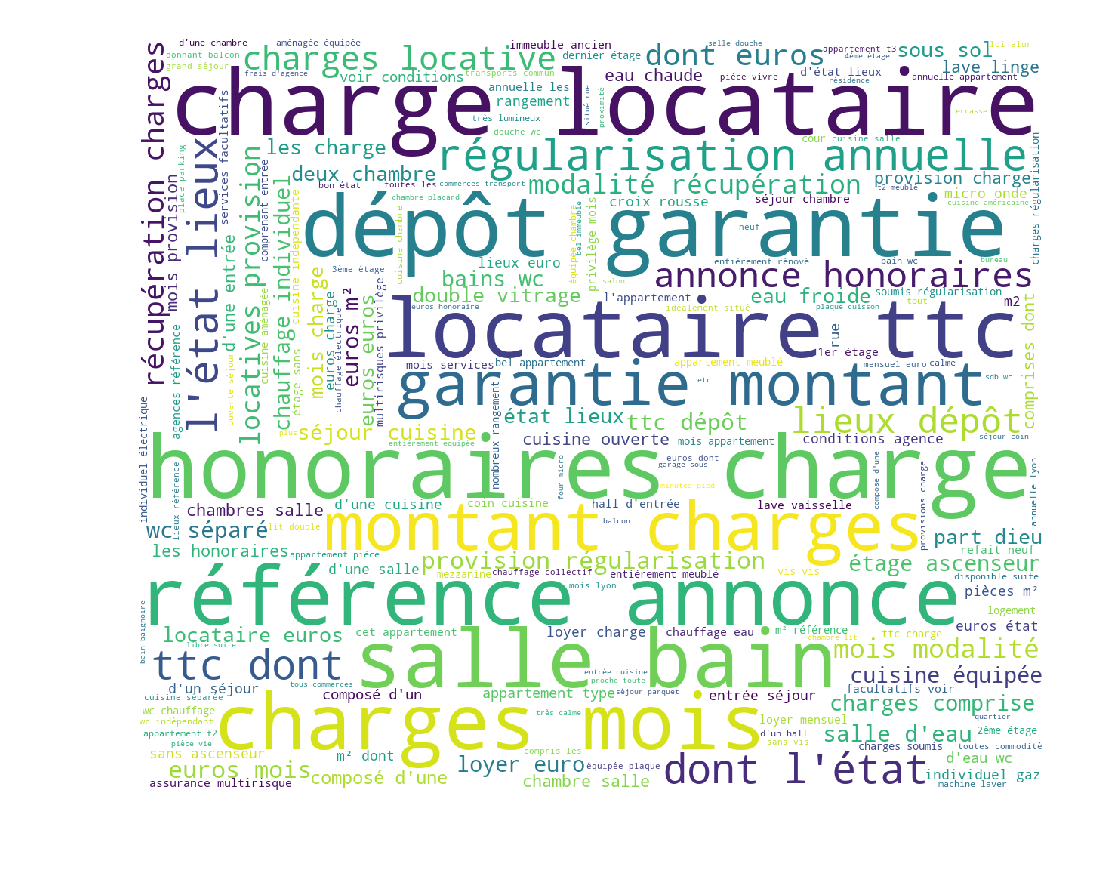

In [38]:
wordcloud = WordCloud(stopwords=stopwords.words("french"),
                          background_color='white',
                          width=1200,
                          height=1000,
                         ).generate(' '.join(text_desc).lower())

plt.figure(figsize=(6, 4),dpi = 250)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Most of the words are part of the 

In [39]:
text_dist=nltk.FreqDist(text_desc)
text_dist.most_common(20)

[('€', 5011),
 ('charges', 2929),
 ('mois', 1891),
 ('euros', 1697),
 ('cuisine', 1634),
 ('locataire', 1621),
 ('charge', 1521),
 ('salle', 1491),
 ('dont', 1468),
 ('TTC', 1427),
 ('Honoraires', 1371),
 ('garantie', 1302),
 ('Dépôt', 1258),
 ('lieux', 1212),
 ('Référence', 1164),
 ('annonce', 1163),
 ('séjour', 1132),
 ('2', 1120),
 ('chambre', 1066),
 ("d'une", 1060)]

In [40]:
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

In [41]:
text_stemmed = [stemmer.stem(w) for w in nltk.word_tokenize(text_desc)]

TypeError: expected string or bytes-like object

In [ ]:
wordcloud = WordCloud(stopwords=stopwords.words("french"),
                          background_color='white',
                          width=1200,
                          height=1000,
                         ).generate(' '.join(text_stemmed))

plt.figure(figsize=(6, 4),dpi = 250)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()